In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Suzuki.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Alto,Seri_Baleno,Seri_Maruti,...,Model_1.3 MT 4X4,Model_1.5 AT,Model_1.6,Model_1.6 GLX,Model_800,Model_GL,Yakıt Tipi_Benzin,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik
0,379500,0.181818,0.555556,0.125000,0.104869,NaN,NaN,0,0,0,...,0,0,0,0,0,1,1,0,1,0
1,364000,0.000000,-0.250000,-1.115385,-0.426966,NaN,NaN,0,0,0,...,1,0,0,0,0,0,1,0,1,0
2,415000,0.000000,-0.194444,-1.528846,-0.771536,5.0,3.0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,140000,-1.636364,-1.361111,-2.725962,-0.561798,NaN,NaN,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,275000,-0.363636,-0.250000,-1.115385,0.726592,11.0,1.0,0,0,0,...,1,0,0,0,0,0,0,1,1,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_10644\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,46003.506908,2.227317e+09,47194.456728,37236.874107


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-05-23 21:32:13,018] A new study created in memory with name: no-name-d96f5353-cff9-478c-adfc-e19bf814d602
[I 2023-05-23 21:32:13,107] Trial 0 finished with value: 311268.37722494395 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.01912041276367185, 'max_depth': 4, 'min_child_weight': 270}. Best is trial 0 with value: 311268.37722494395.
[I 2023-05-23 21:32:13,111] Trial 1 finished with value: 311268.37722494395 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.0002794071428505651, 'max_depth': 12, 'min_child_weight': 285}. Best is trial 0 with value: 311268.37722494395.
[I 2023-05-23 21:32:13,112] Trial 4 finished with value: 311268.37722494395 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.005215315241898411, 'max_depth': 4, 'min_child_weight': 89}. Best is trial 0 with value: 311268.37722494395.
[I 2023-05-23 21:32:13,113] Trial 3 finished with value: 311268.37722494395 and parameters:

[I 2023-05-23 21:32:13,919] Trial 27 finished with value: 311268.37722494395 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.015178581253908426, 'max_depth': 6, 'min_child_weight': 129}. Best is trial 23 with value: 276737.6476442408.
[I 2023-05-23 21:32:13,924] Trial 30 finished with value: 311268.37722494395 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.017304694609943126, 'max_depth': 5, 'min_child_weight': 132}. Best is trial 23 with value: 276737.6476442408.
[I 2023-05-23 21:32:13,939] Trial 29 finished with value: 311268.37722494395 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.010259376219836585, 'max_depth': 5, 'min_child_weight': 125}. Best is trial 23 with value: 276737.6476442408.
[I 2023-05-23 21:32:13,985] Trial 32 finished with value: 311268.37722494395 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.01610839324077311, 'max_depth': 5, 'min_child_

[I 2023-05-23 21:32:15,177] Trial 61 finished with value: 302672.9838572017 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.00371392633270612, 'max_depth': 11, 'min_child_weight': 25}. Best is trial 57 with value: 163641.60753251967.
[I 2023-05-23 21:32:15,187] Trial 60 finished with value: 301666.5773603398 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.004157782156590804, 'max_depth': 12, 'min_child_weight': 25}. Best is trial 57 with value: 163641.60753251967.
[I 2023-05-23 21:32:15,206] Trial 59 finished with value: 155696.66012335801 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.109137802911335, 'max_depth': 12, 'min_child_weight': 25}. Best is trial 59 with value: 155696.66012335801.
[I 2023-05-23 21:32:15,215] Trial 63 finished with value: 148931.61875322482 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.13060648125809085, 'max_depth': 12, 'min_child_we

[I 2023-05-23 21:32:16,575] Trial 89 finished with value: 93073.57937988 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.23582352926042305, 'max_depth': 14, 'min_child_weight': 12}. Best is trial 78 with value: 74927.54790603314.
[I 2023-05-23 21:32:16,638] Trial 90 finished with value: 100132.26064769679 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.22710559330942437, 'max_depth': 14, 'min_child_weight': 15}. Best is trial 78 with value: 74927.54790603314.
[I 2023-05-23 21:32:16,709] Trial 91 finished with value: 311268.37722494395 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.23446502759040755, 'max_depth': 14, 'min_child_weight': 248}. Best is trial 78 with value: 74927.54790603314.
[I 2023-05-23 21:32:16,771] Trial 93 finished with value: 311268.37722494395 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.28735475201202254, 'max_depth': 14, 'min_child_weigh

[I 2023-05-23 21:32:18,019] Trial 119 finished with value: 88707.21804540434 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.3084584625328144, 'max_depth': 14, 'min_child_weight': 8}. Best is trial 108 with value: 59360.2526645708.
[I 2023-05-23 21:32:18,061] Trial 120 finished with value: 85051.85449580761 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.31628317057318384, 'max_depth': 14, 'min_child_weight': 9}. Best is trial 108 with value: 59360.2526645708.
[I 2023-05-23 21:32:18,062] Trial 121 finished with value: 88697.91712629405 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.30852773750423906, 'max_depth': 14, 'min_child_weight': 8}. Best is trial 108 with value: 59360.2526645708.
[I 2023-05-23 21:32:18,124] Trial 122 finished with value: 91201.89128436251 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.2969296147545917, 'max_depth': 14, 'min_child_weight'

[I 2023-05-23 21:32:19,419] Trial 149 finished with value: 79549.74143975248 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.360365905715769, 'max_depth': 12, 'min_child_weight': 6}. Best is trial 130 with value: 56425.62769488632.
[I 2023-05-23 21:32:19,522] Trial 150 finished with value: 64389.08539047288 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.3658113521331512, 'max_depth': 12, 'min_child_weight': 1}. Best is trial 130 with value: 56425.62769488632.
[I 2023-05-23 21:32:19,609] Trial 151 finished with value: 92078.97262922578 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.36870276688917725, 'max_depth': 10, 'min_child_weight': 17}. Best is trial 130 with value: 56425.62769488632.
[I 2023-05-23 21:32:19,671] Trial 152 finished with value: 63724.74711141846 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.35974059977362177, 'max_depth': 15, 'min_child_weig

[I 2023-05-23 21:32:21,010] Trial 178 finished with value: 59427.85347378419 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.403717964538807, 'max_depth': 13, 'min_child_weight': 2}. Best is trial 158 with value: 53447.810924702135.
[I 2023-05-23 21:32:21,037] Trial 180 finished with value: 63483.19522711483 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.3653080896383312, 'max_depth': 13, 'min_child_weight': 1}. Best is trial 158 with value: 53447.810924702135.
[I 2023-05-23 21:32:21,110] Trial 182 finished with value: 59200.314199001645 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.35605481071943906, 'max_depth': 13, 'min_child_weight': 1}. Best is trial 158 with value: 53447.810924702135.
[I 2023-05-23 21:32:21,129] Trial 181 finished with value: 59788.68137554795 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.34436423376756187, 'max_depth': 13, 'min_child_w

[I 2023-05-23 21:32:22,755] Trial 209 finished with value: 57943.81162496055 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.31098317314201757, 'max_depth': 13, 'min_child_weight': 1}. Best is trial 158 with value: 53447.810924702135.
[I 2023-05-23 21:32:22,771] Trial 210 finished with value: 62493.25375259921 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.32425499626524656, 'max_depth': 13, 'min_child_weight': 1}. Best is trial 158 with value: 53447.810924702135.
[I 2023-05-23 21:32:22,808] Trial 211 finished with value: 269026.9638862662 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.019398455254087215, 'max_depth': 13, 'min_child_weight': 1}. Best is trial 158 with value: 53447.810924702135.
[I 2023-05-23 21:32:22,841] Trial 212 finished with value: 62860.21920355705 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.3202293688796216, 'max_depth': 13, 'min_child

[I 2023-05-23 21:32:24,509] Trial 239 finished with value: 299270.21076279494 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.00507204777615536, 'max_depth': 13, 'min_child_weight': 6}. Best is trial 229 with value: 52194.131121179445.
[I 2023-05-23 21:32:24,607] Trial 241 finished with value: 74196.4420612365 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.3553149201489481, 'max_depth': 13, 'min_child_weight': 6}. Best is trial 229 with value: 52194.131121179445.
[I 2023-05-23 21:32:24,645] Trial 240 finished with value: 75205.11464888744 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.3547238000123205, 'max_depth': 13, 'min_child_weight': 7}. Best is trial 229 with value: 52194.131121179445.
[I 2023-05-23 21:32:24,698] Trial 242 finished with value: 71689.80904900456 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.35849822400810866, 'max_depth': 13, 'min_child_w

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 52194.1311
Best params:
	colsample_bytree: 0.8
	subsample: 1.0
	learning_rate: 0.4246440287784234
	max_depth: 14
	min_child_weight: 1


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)
grid_params = {"learning_rate": [0.1, 0.4],
                  "max_depth": [9,14],
                  "n_estimators": [500,750,1000],
               'colsample_bytree': [0.8],
               'subsample': [1],
               'min_child_weight': [1]
              }

grid_model = GridSearchCV(estimator=model,
                                  param_grid=grid_params,
                                  cv=3,
                                  verbose=True,
                                  n_jobs=1).fit(X_train,y_train)


grid_final_model = model.set_params(**grid_model.best_params_).fit(X_train,y_train)
    
cv_results = cross_validate(grid_final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
print("BEST PARAMS: ", grid_model.best_params_)
    
y_pred = grid_final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
BEST PARAMS:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 1000, 'subsample': 1}
{'TestDeger': 46228.56588709113, 'MSE': 2200555781.2346873, 'RMSE': 46910.08187196743, 'MAE': 37636.741741071426}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.9311922770547701

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.8803343948778611

In [17]:
marka_model = joblib.dump(grid_final_model, "Suzuki.pkl")

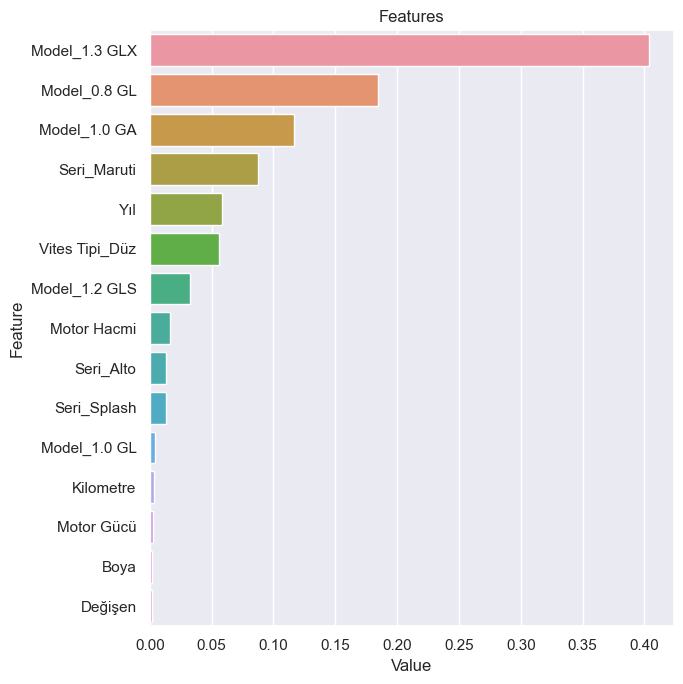

In [16]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(grid_final_model,X)